In [1]:
import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
# from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
import warnings

In [2]:
from utils import read_txn_data, preprocess_txn_data, compute_lob_features, create_lob_dataset, merge_txn_and_lob

### Data Loading

In [ ]:
trx_df = read_txn_data(use_load=False)
trx_df = preprocess_txn_data(trx_df, freq='1min')

lob_df = create_lob_dataset(use_load=False)

df_merged = merge_txn_and_lob(trx_df, lob_df)
df_merged.head()

trx Data loaded successfully.


### ARMA-GARCH

In [5]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 8,4

In [6]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [7]:
trx_df.loc[trx_df.isna().any(axis=1)]

,datetime,buy_volume,sell_volume,buy_txn,sell_txn,volume_imbalance,txn_imbalance,total_volume,mean_volume,deseasoned_total_volume


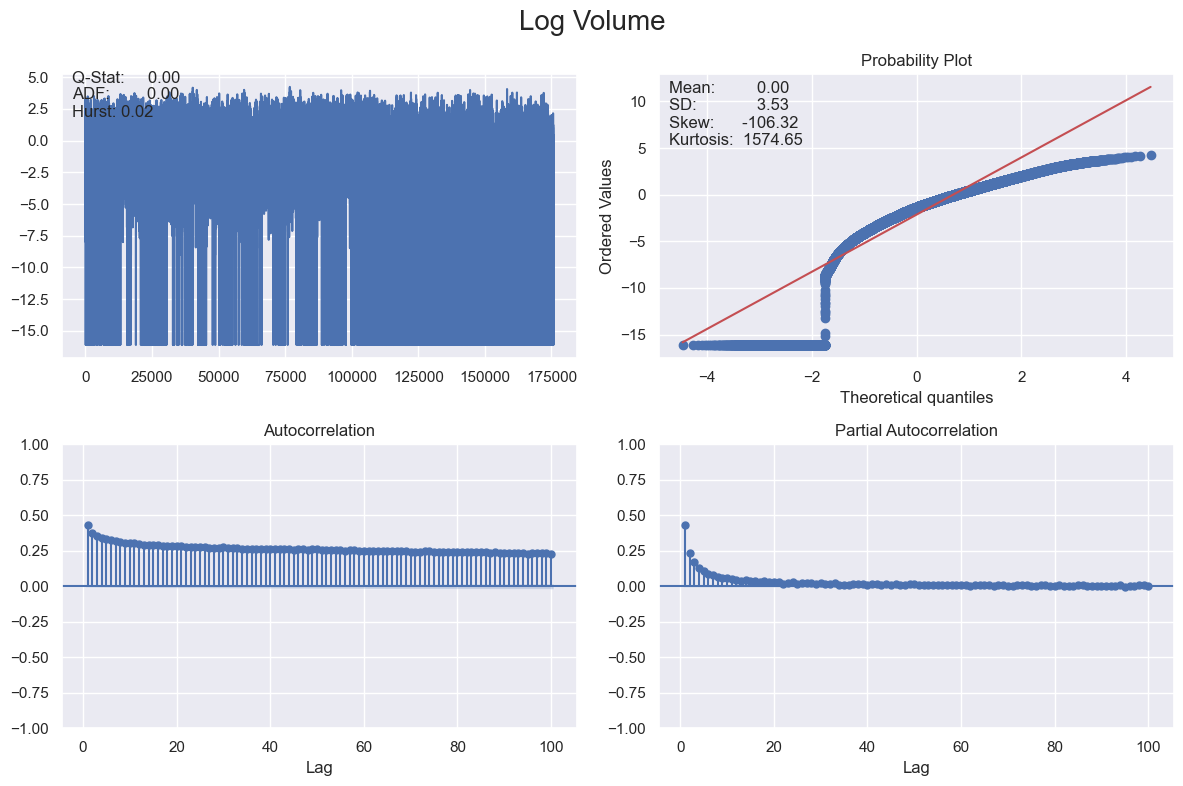

In [10]:
trx_df['log_deseasoned_total_volume'] = np.log(trx_df['deseasoned_total_volume'] + 1e-07)

# Plot ACF, PACF and Q-Q plot and get ADF p-value of series
plot_correlogram(trx_df['log_deseasoned_total_volume'], lags=100, title='Log Volume')

In [11]:
# Specify GARCH model assumptions
basic_gm = arch_model(trx_df['log_deseasoned_total_volume'], p = 1, q = 1,
                      mean = 'ARX', lags=2, vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(update_freq = 4)

Iteration:      4,   Func. Count:     51,   Neg. LLF: 1199840.4373813402
Iteration:      8,   Func. Count:     87,   Neg. LLF: 416967.6944277597
Iteration:     12,   Func. Count:    121,   Neg. LLF: 414467.7375567176
Iteration:     16,   Func. Count:    153,   Neg. LLF: 414051.1258784325
Iteration:     20,   Func. Count:    180,   Neg. LLF: 414051.0069895704
Optimization terminated successfully    (Exit mode 0)
            Current function value: 414051.00698957103
            Iterations: 20
            Function evaluations: 180
            Gradient evaluations: 20


In [12]:
print(gm_result.summary())

                                AR - GARCH Model Results                               
Dep. Variable:     log_deseasoned_total_volume   R-squared:                       0.218
Mean Model:                                 AR   Adj. R-squared:                  0.218
Vol Model:                               GARCH   Log-Likelihood:               -414051.
Distribution:                           Normal   AIC:                           828114.
Method:                     Maximum Likelihood   BIC:                           828174.
                                                 No. Observations:               175738
Date:                         Mon, Mar 31 2025   Df Residuals:                   175735
Time:                                 15:31:46   Df Model:                            3
                                 Mean Model                                
                    coef    std err          t      P>|t|  95.0% Conf. Int.
--------------------------------------------------------

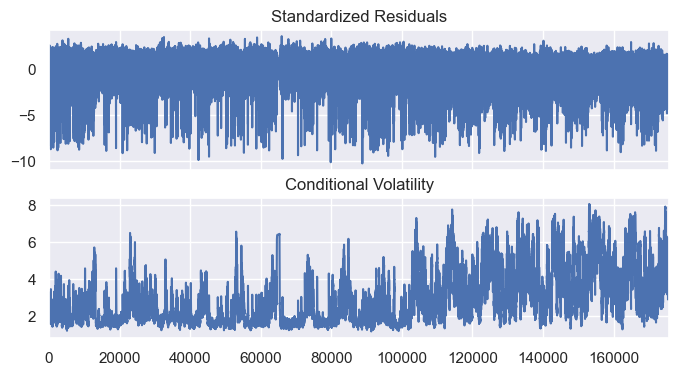

In [13]:
# Plot fitted results
gm_result.plot()
plt.show()

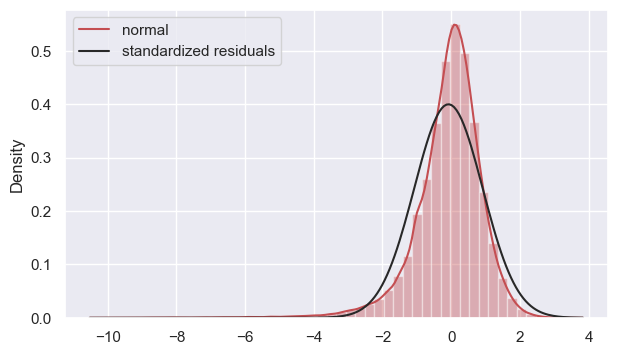

In [14]:
# Obtain model estimated residuals and volatility
gm_resid = gm_result.resid
gm_std = gm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Plot the histogram of the standardized residuals
plt.figure(figsize=(7,4))
sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50, color='r')
plt.legend(('normal', 'standardized residuals'))
plt.show()

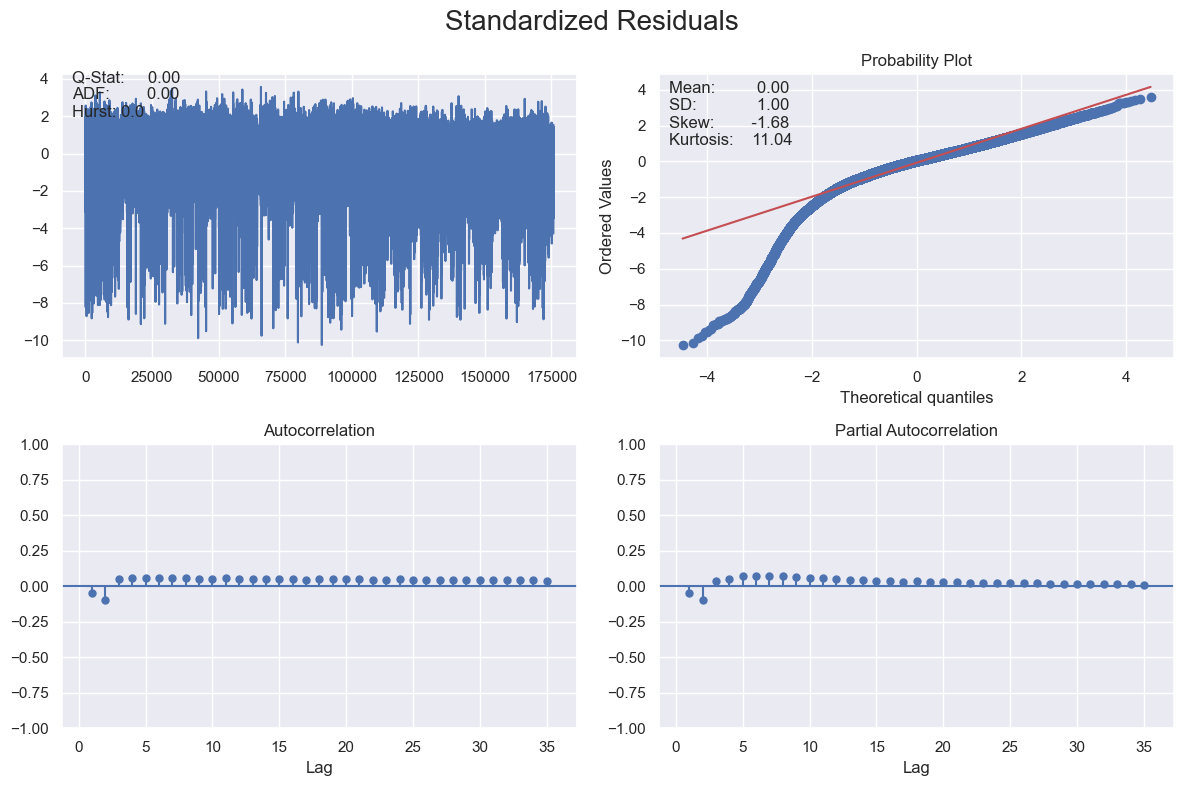

In [18]:
plot_correlogram(gm_std_resid.dropna(), lags=35, title='Standardized Residuals')